# Part4 Topic Modeling

In [159]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [160]:
## Importing Basic Packages
import matplotlib.pyplot as plt
import numpy as np

# Import NLP Packages
import re
import nltk
from wordcloud import WordCloud

# NLTK Stop words
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

from textblob import Word

In [161]:
spark = SparkSession.builder.config('spark.driver.memory', '8g').config('spark.executor.memory','8g').config('spark.driver.maxResultSize','0').config('spark.sql.autoBroadcastJoinThreshold','-1').config('spark.sql.broadcastTimeout','1200').config('spark.default.parallelism','8').config('spark.executor.heartbeatInterval','3600s').appName("topicmodeling").getOrCreate()

## Part 3 Review

In [162]:
path = 'part3_superscore_review.csv'
review = spark.read.csv(path, header=True, multiLine=True)

In [163]:
review.count()

560305

In [164]:
dropped_review = review.filter(review.polarity == 0.0)
dropped_review = dropped_review.filter(dropped_review.subjectivity == 0.0)
dropped_review = dropped_review.filter(dropped_review.compound == 0.0)

In [165]:
dropped_id_set = set()
for i in list(dropped_review.select('review_id').collect()):
    dropped_id_set.add(i[0])

In [166]:
print(len(dropped_id_set))

971


In [167]:
combined_review = review.filter(review['review_id'].isin(dropped_id_set) == False)

In [168]:
print(combined_review.count()) # 559334 + 971 = 560305

559334


In [169]:
combined_review.show(3)

+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+--------------------+-------------------+------------------+--------+------------------+
|           review_id|         business_id|             user_id|year|month|day|stars|useful|funny|cool|                text|        cleaned_text|           polarity|      subjectivity|compound|        superscore|
+--------------------+--------------------+--------------------+----+-----+---+-----+------+-----+----+--------------------+--------------------+-------------------+------------------+--------+------------------+
|EO5rALvJMkK8QEvUN...|9P-lp3AWDXGayDqJz...|u2xPfv6_wcKt-lW-C...|2018|    2| 11|  2.0|     0|    0|   0|The ramen here is...|ramen le great ca...|                0.7|             0.675|  0.5132|          2.242487|
|oL2y3mXe_qab349DP...|0nMbLN0B5I-2tNnQL...|4cDqW9sWnZ57tsIEi...|2017|   12|  2|  5.0|     4|    4|   4|"Even the mad Cap...|mad captain ahab ...|0.1

In [170]:
dropped_text = dropped_review.select(['text'])

In [171]:
dropped_text.show(10, truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In [172]:
combined_review = combined_review.dropna()
print(combined_review.count())

559331


In [173]:
combined_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- text: string (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- subjectivity: string (nullable = true)
 |-- compound: string (nullable = true)
 |-- superscore: string (nullable = true)



### Topic Forsight

In [174]:
# Topic Modeling
from pyspark.sql import SQLContext, Row
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.ml.feature import CountVectorizer, StopWordsRemover, RegexTokenizer, IDF

tp_reviews = combined_review.select(['review_id','text'])

tokenizer = RegexTokenizer().setInputCol("text").setOutputCol("words").setPattern("\\W")
wordsData = tokenizer.transform(tp_reviews)


remover = StopWordsRemover(inputCol="words", outputCol="filtered")
filter_data = remover.transform(wordsData)


cv = CountVectorizer(inputCol='filtered', outputCol='vectors',minDF=2.0, vocabSize=1000)
model = cv.fit(filter_data)


In [175]:
result = model.transform(filter_data)

In [176]:
result = result.select("*").withColumn("id", monotonically_increasing_id())
result.show(3)

+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|           review_id|                text|               words|            filtered|             vectors| id|
+--------------------+--------------------+--------------------+--------------------+--------------------+---+
|EO5rALvJMkK8QEvUN...|The ramen here is...|[the, ramen, here...|[ramen, less, gre...|(1000,[1,3,5,37,2...|  0|
|oL2y3mXe_qab349DP...|"Even the mad Cap...|[even, the, mad, ...|[even, mad, capta...|(1000,[3,4,8,11,1...|  1|
|OH9E5SaGBQsPX3Ikt...|It's crazy how es...|[it, s, crazy, ho...|[crazy, establish...|(1000,[0,4,11,15,...|  2|
+--------------------+--------------------+--------------------+--------------------+--------------------+---+
only showing top 3 rows



In [177]:
corpus = result.select(['id','vectors']).rdd.map(lambda x: [x[0],Vectors.fromML(x[1])]).cache()

In [178]:
ldaModel = LDA.train(corpus, k=7,maxIterations=50,optimizer='online')
topics = ldaModel.topicsMatrix()
vocabArray = model.vocabulary

In [179]:
wordNumbers = 10  # number of words per topic
topicIndices = spark.sparkContext.parallelize(ldaModel.describeTopics(maxTermsPerTopic = wordNumbers))

In [180]:
def topic_render(topic):  # specify vector id of words to actual words
    terms = topic[0]
    result = []
    for i in range(wordNumbers):
        term = vocabArray[terms[i]]
        result.append(term)
    return result

topics_final = topicIndices.map(lambda topic: topic_render(topic)).collect()

In [181]:
for topic in range(len(topics_final)):
    print ("Topic" + str(topic) + ":")
    for term in topics_final[topic]:
        print (term)
    print ('\n')

Topic0:
like
place
get
one
time
m
good
coffee
go
really


Topic1:
food
us
pizza
service
order
time
back
one
came
table


Topic2:
food
great
place
service
portland
best
friendly
love
amazing
always


Topic3:
food
good
chicken
like
place
sauce
ordered
rice
pork
really


Topic4:
good
cream
ice
wait
place
got
chicken
food
get
line


Topic5:
great
good
place
food
beer
bar
happy
hour
service
nice


Topic6:
good
delicious
great
fresh
really
also
one
best
sweet
portland




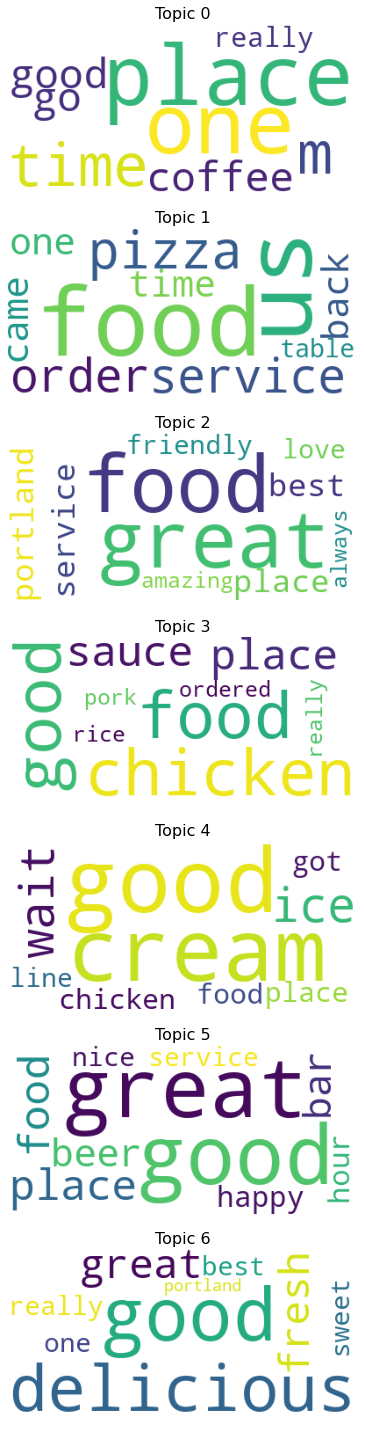

In [182]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

fig, axes = plt.subplots(7, 1, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = topics_final[i]
    wordcloud_low = WordCloud(background_color="white").generate(' '.join(topic_words))
    plt.gca().imshow(wordcloud_low)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=5, y=5)
plt.tight_layout()
plt.show()

### LDA Training

In [183]:
from pyspark.ml.clustering import LDA

dataset = result.select(['review_id','text','vectors'])

mllda = LDA(featuresCol="vectors",k=7, maxIter=50)
mlmodel = mllda.fit(dataset)

In [184]:
# Describe topics.
topics = mlmodel.describeTopics()
topics.show(truncate=False)

+-----+--------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|termIndices                                 |termWeights                                                                                                                                                                                                                  |
+-----+--------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|0    |[2, 1, 4, 0, 7, 36, 3, 13, 11, 12]          |[0.024151565489700055, 0.01844928850923845, 0.015510885628798727, 0.015266937819071251, 0.012589763246800861, 0.01165793591

In [185]:
from operator import itemgetter 
key_topics = [[] for _ in range(7)]

for i in topics['topic','termIndices'].collect():
    key_topics[i['topic']] = list(itemgetter(*i['termIndices'])(model.vocabulary))

print(key_topics)

[['place', 'good', 'like', 'food', 'get', 'always', 'great', 've', 'go', 'portland'], ['food', 'great', 'good', 'service', 'place', 'back', 'happy', 'amazing', 'friendly', 'delicious'], ['food', 'good', 'chicken', 'like', 'ordered', 'sauce', 'place', 'rice', 'really', 'pork'], ['cream', 'ice', 'donuts', 'flavors', 'good', 'ramen', 'like', 'place', 'chocolate', 'line'], ['place', 'breakfast', 'great', 'coffee', 'delicious', 'food', 'love', 'friendly', 'good', 'wait'], ['food', 'us', 'time', 'service', 'one', 'order', 'get', 'back', 'place', 'like'], ['pizza', 'sandwich', 'cheese', 'good', 'vegan', 'free', 'delicious', 'great', 'place', 'best']]


In [186]:
transformed = mlmodel.transform(dataset)

In [187]:
transformed.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- vectors: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)



In [188]:
from pyspark.ml.functions import vector_to_array
transformed = transformed.withColumn("topicDistribution", vector_to_array("topicDistribution"))

In [189]:
def tran_keywords(value):
    max_index = int(np.argmax(value))
    return key_topics[max_index]

udftran_keywords = udf(tran_keywords, ArrayType(StringType()))
transformed = transformed.withColumn("Keywords", lit(udftran_keywords("topicDistribution")))


In [190]:
transformed = transformed.drop('vectors')

In [191]:
transformed = transformed.drop('topicDistribution')

In [192]:
transformed.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- text: string (nullable = true)
 |-- Keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [193]:
transformed.show(2,truncate=False)

+----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------+
|review_id             |text                                                                                                                                                        

In [194]:
transformed = transformed.withColumnRenamed("review_id","trans_id")
transformed = transformed.withColumnRenamed("text","trans_text")

In [195]:
transformed.printSchema()

root
 |-- trans_id: string (nullable = true)
 |-- trans_text: string (nullable = true)
 |-- Keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [196]:
transformed.count()

559331

In [197]:
final_review = combined_review.join(transformed, combined_review.review_id == transformed.trans_id, 'inner')

In [198]:
final_review.count()

559331

In [199]:
final_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- funny: string (nullable = true)
 |-- cool: string (nullable = true)
 |-- text: string (nullable = true)
 |-- cleaned_text: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- subjectivity: string (nullable = true)
 |-- compound: string (nullable = true)
 |-- superscore: string (nullable = true)
 |-- trans_id: string (nullable = true)
 |-- trans_text: string (nullable = true)
 |-- Keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [200]:
final_review = final_review.drop('year')
final_review = final_review.drop('month')
final_review = final_review.drop('day')
final_review = final_review.drop('funny')
final_review = final_review.drop('cool')
final_review = final_review.drop('trans_id')
final_review = final_review.drop('trans_text')
final_review = final_review.drop('cleaned_text')

In [201]:
final_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- text: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- subjectivity: string (nullable = true)
 |-- compound: string (nullable = true)
 |-- superscore: string (nullable = true)
 |-- Keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [202]:
def array_to_string(my_list):
    return '[' + ','.join([str(elem) for elem in my_list]) + ']'

array_to_string_udf = udf(array_to_string, StringType())

final_review = final_review.withColumn('Keywords', array_to_string_udf(final_review["Keywords"]))

In [203]:
final_review.printSchema()

root
 |-- review_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: string (nullable = true)
 |-- useful: string (nullable = true)
 |-- text: string (nullable = true)
 |-- polarity: string (nullable = true)
 |-- subjectivity: string (nullable = true)
 |-- compound: string (nullable = true)
 |-- superscore: string (nullable = true)
 |-- Keywords: string (nullable = true)



In [204]:
final_review.show(2,truncate=True)

+--------------------+--------------------+--------------------+-----+------+--------------------+-------------------+------------------+--------+------------------+--------------------+
|           review_id|         business_id|             user_id|stars|useful|                text|           polarity|      subjectivity|compound|        superscore|            Keywords|
+--------------------+--------------------+--------------------+-----+------+--------------------+-------------------+------------------+--------+------------------+--------------------+
|-07dOtf4Z22eFdRqN...|yI7z8tn26VBcKfBXQ...|ZViP3qO-PHULg8iJL...|  4.0|     0|I give them a 4 s...|                0.8|              0.75|  0.8294|4.4976400000000005|[food,us,time,ser...|
|-08F3wFNcjdGcUV8F...|LG90fiADvCWy5bii3...|eEFHo_VFdkYOYFQAC...|  5.0|     1|You need happy ho...|0.24601449275362325|0.6739130434782609|  0.9971| 5.165311577662256|[food,great,good,...|
+--------------------+--------------------+--------------------+-

# Save to CSV

In [205]:
final_review.write.option("header",True).csv("topicmodeling_review.csv")